In [2]:
using DrWatson

In [3]:
@quickactivate "RxInferThesisExperiments"

In [4]:
using RxInferThesisExperiments, RxInfer, StaticArrays, Plots, PGFPlotsX, LaTeXStrings
using LinearAlgebra, StableRNGs, Random, BenchmarkTools, ColorSchemes, Dates

In [5]:
const bfolder = datadir("hgf", "rxinfer")

"/Users/bvdmitri/.julia/dev/thesis/data/hgf/rxinfer"

In [6]:
# Pregenerate paths for benchmark data
mkpath(bfolder);

In [7]:
const environment = HGFEnvironment()

HGFEnvironment()

In [8]:
# Include the model specification
include(srcdir("models", "rxinfer", "hgf.jl"));

In [9]:
function run_benchmark(params)
    @unpack T, niterations, seed = params
    
    zstates, xstates, observations = rand(StableRNG(seed), environment, T);
    model    = hgf(environment.kappa, environment.omega)
    result   = run_inference(model, observations; iterations = niterations)
    e_states = extract_posteriors(T, result)
    z_amse   = compute_amse(zstates, e_states[:z])
    x_amse   = compute_amse(xstates, e_states[:x])
    
    benchmark_modelcreation = @benchmark RxInfer.create_model(hgf(environment.kappa, environment.omega), 
        constraints = hgfconstraints(),
    )
    
    benchmark_inference = @benchmark run_inference(model, observations; iterations = $niterations) setup=begin
        model = hgf($(environment.kappa), $(environment.omega))
        zstates, xstates, observations = rand(StableRNG($seed), environment, $T);
    end
    
    emse = compute_emse(seed) do _seed
        local zstates, xstates, observations = rand(StableRNG(_seed), environment, T);
        local model    = hgf(environment.kappa, environment.omega)
        local result   = run_inference(model, observations; iterations = niterations)
        local e_states = extract_posteriors(T, result)
        return [ compute_amse(zstates, e_states[:z]), compute_amse(xstates, e_states[:x]) ]
    end
    
    z_emse = emse[1]
    x_emse = emse[2]
    
    states = (z = zstates, x = xstates)
    
    output = @strdict T niterations seed states e_states observations z_amse x_amse z_emse x_emse benchmark_modelcreation benchmark_inference
    
    return output
end

run_benchmark (generic function with 1 method)

In [10]:
# Here we create a list of parameters we want to run our benchmarks with
benchmark_params = dict_list(Dict(
    "T"           => [ 10, 20, 30, 100 ],
    "niterations" => [ 3, 10 ],
    "seed"        => [ 42 ]
));

In [11]:
# First run maybe slow, you may track the progress in the terminal
# Subsequent runs will not create new benchmarks 
# but will reload it from data folder
benchmarks = map(benchmark_params) do params
    result, _ = produce_or_load(run_benchmark, bfolder, params; tag = false, force = false)
    return result
end;

In [12]:
benchmarks_table = sort(prepare_benchmarks_table(bfolder), [ :T ])

[ Info: Scanning folder /Users/bvdmitri/.julia/dev/thesis/data/hgf/rxinfer for result files.
[ Info: Added 8 entries.


Row,T,z_emse,x_emse,z_amse,niterations,seed,x_amse,inference,creation
,Int64?,Float64?,Float64?,Float64?,Int64?,Int64?,Float64?,Tuple…?,Tuple…?
1,10,1.07994,0.158287,0.972368,10,42,0.223043,"(1.99526e6, 2.39058e6, 0.0)","(172670.0, 2.33492e5, 0.0)"
2,10,0.829284,0.160147,0.728915,3,42,0.21214,"(787058.0, 9.71598e5, 0.0)","(172682.0, 1.99842e5, 0.0)"
3,20,0.724445,0.154106,0.556095,10,42,0.186524,"(3.66641e6, 4.98389e6, 0.0)","(172520.0, 2.04684e5, 0.0)"
4,20,0.556865,0.154078,0.449722,3,42,0.181087,"(1.28982e6, 1.58894e6, 0.0)","(168500.0, 2.20081e5, 0.0)"
5,30,0.562733,0.151885,0.41141,10,42,0.164712,"(5.17404e6, 6.25023e6, 0.0)","(171478.0, 207299.0, 0.0)"
6,30,0.433873,0.151497,0.336194,3,42,0.161326,"(1.78294e6, 2.1141e6, 0.0)","(168546.0, 2.06601e5, 0.0)"
7,100,0.228496,0.154488,0.154583,10,42,0.153342,"(1.69788e7, 1.9752e7, 0.0)","(168205.0, 207433.0, 0.0)"
8,100,0.17831,0.154043,0.130839,3,42,0.152361,"(5.43523e6, 6.95584e6, 0.0)","(172491.0, 2.20906e5, 0.0)"


# Extra plots

In [14]:
pgfplotsx()

Plots.PGFPlotsXBackend()

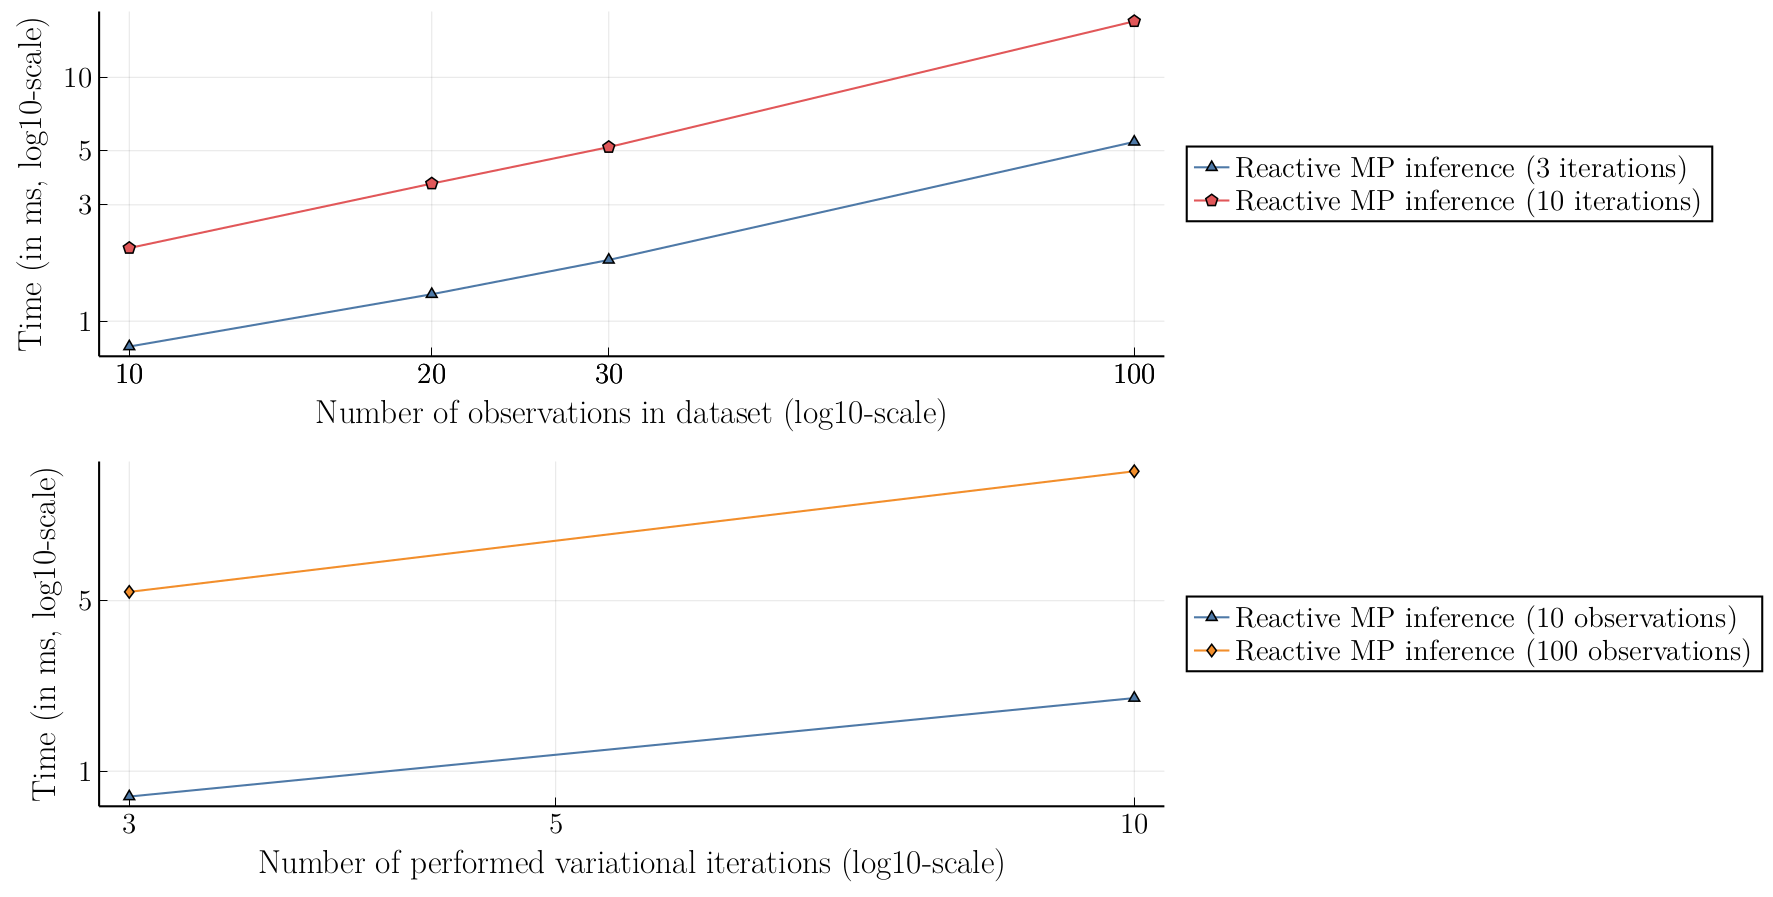

In [16]:
# `plotting`range
colors = ColorSchemes.tableau_10

# Some default settings for plotting
pfontsettings = (
    titlefontsize=18,
    guidefontsize=16,
    tickfontsize=14,
    legendfontsize=14,
    legend = :outerright,
    legend_font_halign = :left,
    size = (800, 300)
)

p1xticks = (benchmarks_table.T, string.(benchmarks_table.T))

p1yticks = (
    [ 1, 3, 5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5_000, 10_000, 30_000, 50_000 ], 
    [ "1", "3", "5", "10", "20", "50", "100", "200", "500", "1e3", "2e3", "5e3", "1e4", "3e4", "5e4" ]
)

p1 = plot(
    xlabel = "Number of observations in dataset (log10-scale)", 
    ylabel = "Time (in ms, log10-scale)"; 
    xscale = :log10,
    yscale = :log10,
    xticks = p1xticks,
    yticks = p1yticks,
    pfontsettings...
)

nitrs = [ 3, 5, 10, 20 ];
mshapes = [ :utriangle, :diamond, :pentagon ]

for (index, (mshape, nitr)) in enumerate(zip(mshapes, nitrs))
    filtered = filter((r) -> r["niterations"] == nitr, benchmarks_table)
    sorted      = sort(filtered, [ :T ])
    range       = map(f -> f["T"], eachrow(sorted))
    t_inference = map(f -> to_ms(f["inference"][1] - f["inference"][3]), eachrow(sorted))
    
    plot!(p1, range, t_inference, label = "Reactive MP inference ($nitr iterations)", marker = mshape, color = colors[index])
end

##

p2xticks = (
    [ 3, 5, 10, 20 ],
    string.([ 3, 5, 10, 20 ])
)

p2yticks = (
    [ 1, 5, 20, 100, 300, 1000, 3_000, 10_000, 3e4, 1e5 ], 
    [ "1", "5", "20", "100", "300", "1e3", "3e3", "1e4", "3e4", "1e5" ]
)

p2 = plot(
    xlabel = "Number of performed variational iterations (log10-scale)", 
    ylabel = "Time (in ms, log10-scale)"; 
    xscale = :log10,
    yscale = :log10,
    xticks = p2xticks,
    yticks = p2yticks,
    pfontsettings...
)

Ts = [ 10, 100, 1000, 10_000 ];
mshapes = [ :utriangle, :diamond, :pentagon, :circle ]

for (index, (mshape, T)) in enumerate(zip(mshapes, Ts))
    filtered = filter((r) -> r["T"] == T, benchmarks_table)
    sorted      = sort(filtered, [ :niterations ])
    range       = map(f -> f["niterations"], eachrow(sorted))
    t_inference = map(f -> to_ms(f["inference"][1] - f["inference"][3]), eachrow(sorted))
    
    plot!(p2, range, t_inference, label = "Reactive MP inference ($T observations)", marker = mshape, color = colors[index])
end

plot(p1, p2, size = (800, 600), layout = @layout([ a; b ]))

# Versions

In [32]:
versioninfo()

Julia Version 1.9.0
Commit 8e630552924 (2023-05-07 11:25 UTC)
Platform Info:
  OS: macOS (x86_64-apple-darwin22.4.0)
  CPU: 12 × Intel(R) Core(TM) i7-8850H CPU @ 2.60GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-14.0.6 (ORCJIT, skylake)
  Threads: 2 on 12 virtual cores


In [33]:
] status

Project RxInferThesisExperiments v1.0.0
Status `~/.julia/dev/thesis/Project.toml`
  [b5ca4192] AdvancedVI v0.2.3
  [6e4b80f9] BenchmarkTools v1.3.2
  [76274a88] Bijectors v0.12.4
  [35d6a980] ColorSchemes v3.21.0
  [a93c6f00] DataFrames v1.5.0
  [31c24e10] Distributions v0.25.95
  [634d3b9d] DrWatson v2.12.5
  [442a2c76] FastGaussQuadrature v0.5.1
  [9fc3f58a] ForneyLab v0.12.0
  [f6369f11] ForwardDiff v0.10.35
  [14197337] GenericLinearAlgebra v0.3.11
  [19dc6840] HCubature v1.5.1
  [7073ff75] IJulia v1.24.0
  [b964fa9f] LaTeXStrings v1.3.0
  [bdcacae8] LoopVectorization v0.12.159
  [3bd65402] Optimisers v0.2.18
  [8314cec4] PGFPlotsX v1.6.0
  [e4faabce] PProf v2.2.2
  [91a5bcdd] Plots v1.38.15
  [92933f4c] ProgressMeter v1.7.2
  [37e2e3b7] ReverseDiff v1.14.6
  [86711068] RxInfer v2.11.0
  [860ef19b] StableRNGs v1.0.0
  [aedffcd0] Static v0.8.7
  [90137ffa] StaticArrays v1.5.25
⌅ [2913bbd2] StatsBase v0.33.21
  [4c63d2b9] StatsFuns v1.3.0
  [fce5fe82] Turing v0.25.1
  [37e2e46d] Line